<img src="images/ie-logo.png" width="200" height="200" align="right">

# MovieLens Recommendation System

## Course: Recommendation Engines

### By Guia, Juan, Leo, Quan

### Table of Contents

* [Introduction](#1)
* [Dataset](#2)
* [Data Pre-Processing](3#)
    * [Rating Data: Ratings](3.1#)
    * [Item Data: Movies](3.2#)
    * [User Data: Demographics](3.3#)
    * [User Item Data: Tag & Genome](3.4#)
* [Recommendation Systems](4#)
    * [Collaborative Filtering](4.1#)
    * [Content-Based Filtering](4.2#)
    * [Popularity](4.3#)
    * [Weighted Hybrid Recommendation](4.4#)
* [Our Recommender Systems](5#)
* [Conclusion](6#)

---

# Introduction <a class="anchor" id="1"></a>

If you have an account for any streaming services such as Netflix or Prime Video, you probably have noticed how you keep getting recommended with the best possible movies. The question therefore arises: “How do companies do that?”. The secret here is recommendation system, as it understands the needs of the users and provides satisfactory suggestions of the various cinematographic products you should watch. It does this by looking at the information about the user as an input and processes it to predict how much the user would rate the movie. There are several recommendation systems that can be used to provide these movie recommendations. 

As a matter of fact, the objective of this report is to investigate the different recommendation system on a database which contains information regarding users, movies, and ratings. We will go in depths on how to perform exploratory data analysis and perform fine tuning to select the best parameters for each system. The recommendation systems we will be analysing are Collaborative filtering, Content-Based filtering, Hybrid User-Item Based Collaborative filtering, Popularity Based filtering. 

# Dataset <a class="anchor" id="2"></a>

This dataset describes 5-star rating and free-text tagging activity from a movie recommendation service called MovieLens. It contains 100836 ratings across 58098 movies. These data were created based on 610 users who were selected at random, between January 09, 1995 and September 26, 2018. Moreover, user IDs are consistent in both the ratings and tags file and ensure privacy as they are anonymized. 
The data is contained in the files `movies.csv`, `rating.csv`, `tags.csv`, `genome-scores.csv`, `genome-tags.csv` and `links.csv`. The movie dataset contains the title, genre and id of all the movies that received at least one rating from a user. Ratings contains the movie and user ID, as well as the rating which are made on a 5-star scale, with half-star increments. The tag file contains movie ID, user ID, and user-generated metadata about movies. Similarly, the genome-scores and genome-tag files contain tag relevance scores for movies.


# Data Pre-processing <a class="anchor" id="3"></a>

Now that we understood what the data is about and what each file contains, we must perform data pre-processing for each file.

## Rating Data: Ratings <a class="anchor" id="3.1"></a>

In [5]:
ratings = pd.read_csv("./Data/ratings.csv")
ratings.shape

(100836, 4)

This data contains 100836 raiting in total. After having imported the dataset, we start by ensuring that each user has rated at least one movie and analyse the summary of statistics. Hence, we can observe from the output bellow how out of the 610 users where more than half rated over 70 movies. Moreover, 20% of the observations come from the same 12 user who rated over 1000 movies each, the subjectivity of these few might affect the models’ prediction. 

In [6]:
ratings.groupby('userId').movieId.size().describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64

Next, we analysed average rating distribution to ensure it had a bell-shaped curve. In fact, as we can clearly see from the graph below, the curve of the histogram tends to follow a normal distribution, which allows us to apply different calculations and overall its beneficial for model building. However, from the graph we can also see an outlier who has an average rating lower than 1.5; therefore, we can take into consideration removing this user as it can be labelled as a black sheep in this dataset.

Text(0.5, 0.98, 'Rating Distribution')

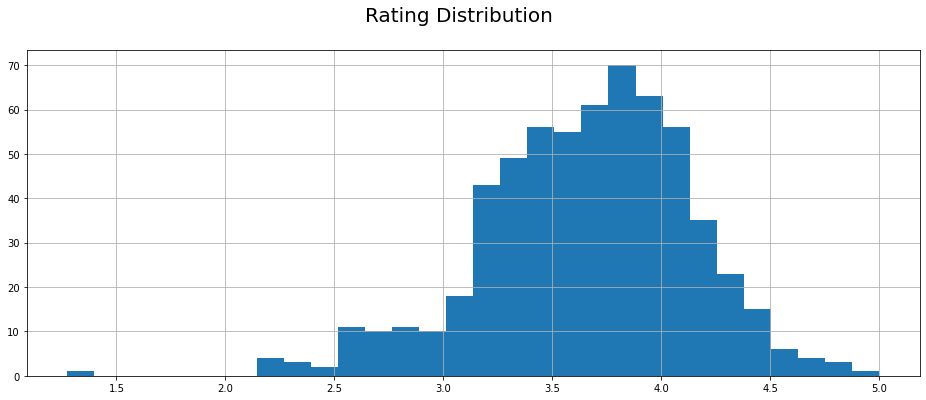

In [36]:
ratings.groupby('userId').rating.mean().hist(bins=30)
plt.suptitle("Rating Distribution", size=20)

In [ ]:
ratings['outlier'] = ratings.userId == 442

## Item Data: Movies <a class="anchor" id="3.2"></a>

In [11]:
movies = pd.read_csv("./Data/movies.csv")
movies.shape

(58098, 3)

Item data represents the data with all the movie titles (58098) which have received at least one rating by a user. However, this table requires some table transformations. 

Firstly, in the title variable we have both the title and the publishing date which could be confusing. Therefore, we proceeded to separate them by removing the date from the title and placing it in a new column. Secondly, we dummified all movie genres (19 excluding the movies with no genre) helping us transform a categorical variable into an indicator variable.

<b>Before:</b>

In [12]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<b>After:</b>

In [14]:
movies.head()

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,1995.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,1995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,1995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,1995.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User Data: Demographics <a class="anchor" id="3.3"></a>

In [17]:
demographics = pd.read_csv("./Data/u.user.csv", header=None, sep='|')
demographics.shape

(943, 5)

We managed to retrieve user information that enabled us to understand the users preferred genres, instead of having to rely on the meta data of the tags and genome. Said additional user information were retrieved from an another version of this same dataset, like age, gender, occupation and zip code. In this dataset it appears that we have more users (333 users more) than the number of users we had in the rating dataset, with all the demographic information of each, such as: gender, age, occupation and location. This is because ratings is a dataset composed of all ratings the user made, meaning that the larger number of users is because of the users who did not assign any rating to any movie. 

Text(0.5, 0.98, 'User Age Distribution')

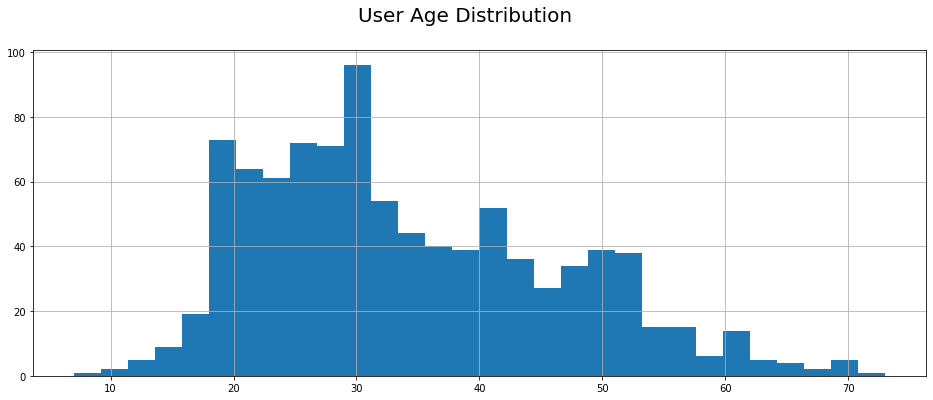

In [38]:
demographics.age.hist(bins=30)
plt.suptitle("User Age Distribution", size=20)

From the distribution of users by age we can conclude that the majority of the watchers are young students. Looking at gender, we observed that are not equally represented as they amount to only 29% of the user, however gender does not appear to have any correlation with age. Location was as well another important variaabble to include when making recommendations as people from similar areas might have a better affinity and taste than people from the opposite coasts, below you can see the plot of the user distribution in the united states

<img src="images/user_location.png" width="600" height="700" align="bottom">

## User Item Data: Tag & Genome <a class="anchor" id="3.4"></a>

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user. Meanwhile, tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome. The tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews. However, by using the genome tag we would lose the user-item interaction, which we have when we use only the tags that the user inserted on the movie. Reason why, we proceeded to only use the top relevant tags and discard the genome tags. Which were found by first excluding all tags that were made by users who were not listed in our rating data. Then, we tried reducing the cardinality of tags by first computing the Levenshtein distance between words and do an affinity propagation. Which resulted less efficient than just cleaning the tags and retaining the most popular ones.

# Recommendation Systems: <a class="anchor" id="4"></a>

## Collaborative Filtering <a class="anchor" id="4.1"></a>

Collaborative filtering models use the collaborative power of the ratings provided by multiple users to make recommendations. These recommendations are in fact based on the similar profiles of its users. The main advantage of collaborative filtering is that it is independent of the product knowledge. Instead, it relies on the users with a basic assumption that what the users liked in the past will also like in the future. For example, if a person A watches crime, sci-fi and thriller genres and B watches sci-fi, thriller and action genres then A will also like action and B will like crime genre. It assumes that other users’ opinions can be aggregated in such a way as to predict the preference of a user. Thus, the prediction is not influenced by item features. Since human’s opinion is involved, the quality of information gained becomes better and more accurate if it compares to approach that only depends on computer intelligence. However, this approach also has drawbacks. Pure collaborative filtering cannot deal with early rater problem. It cannot provide a prediction for a new item or an item that has not been rated by any user since there is no users’ ratings to compute the prediction. 

We can achieve this by following these steps:
1. Select users (neighbours) that have common rated items with the active user
2. Calculate the similarities between all neighbours and the active user
3. Make the estimation by similarity of the neighbours of the active user
4. Catch the most similar top-k neighbours
5. Calculate the estimated rating of the active user using the chosen top-k

First, we must perform some exploratory data analysis to ensure this data is adequate for Collaborative filtering.

Text(0.5, 0.98, 'Ratings per Movie')

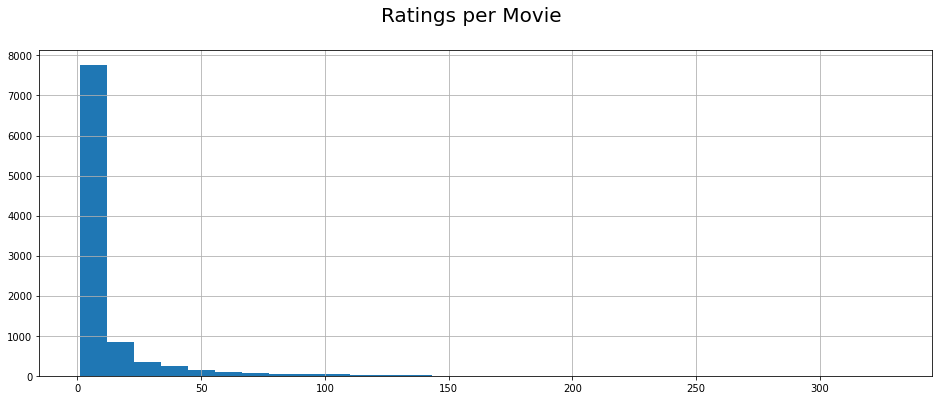

In [48]:
ratings.movieId.value_counts().hist(bins=30)
plt.suptitle("Ratings per Movie", size=20)

As a matter of fact, by calculating the number of movies in the rating data, we unveiled that a lot of movies were rated only once. This is a problem for collaborative filtering, as it relies on a big database in order to actually work. All predictions for movies with one rating will be the one rating already in training. Moreover, if some of those movies are in the test set, then it would be impossible to predict. Therefore, we decided to exclude all movies that had only one rating as they were not good candidates for the evaluation. 

Once the data was split between train and test and the EDA had been finalized, we focused on tuning the parameters. Therefore, we created grid parameters to loop through the model in order to find the best ones. The parameters we focused on were: picking for the most adequate similarity function, selecting the number of shared items once the similarity is established, select how many neighbours are picked (k) and normalize when aggregating by neighbours.  

In [ ]:
sim_options = {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
               'user_based':[True], 
               'min_support': [2, 8]} 

knn_params = {'k':np.arange(30,51,5),
            'min_k':[1, 2, 4],
            'sim_options': sim_options}

svd_params = {'n_factors':[50,100,150],
              'n_epochs':[20,30],
              'lr_all':[0.005,0.01],
              'reg_all':[0.02,0.1]}

In [ ]:
# Define Algorithms and Validation Scheme

models = (NormalPredictor, BaselineOnly, SlopeOne, CoClustering, # No Tuning
          KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, 
          SVD, SVDpp)
kf = KFold(random_state=random_state)

# DataFrame to put results in
results = pd.DataFrame({"RMSE":None, 
                        "MAE":None, 
                        "Fit Time": None, 
                        "Test Time": None, 
                        "Parameters":None}, index=[model.__name__ for model in models])

# Optimize and train all models
for model in models:
    print(f'Training {model.__name__}...')
    if model.__name__ in ('NormalPredictor', 'BaselineOnly', 'SlopeOne', 'CoClustering'): 
        out = cross_validate(model(), data, ['rmse', 'mae'], kf)
        results.loc[model.__name__] = [round(np.mean(out['test_rmse']), 2), 
                                       round(np.mean(out['test_mae']), 2),
                                       round(np.mean(out['fit_time']), 2),
                                       round(np.mean(out['test_time']), 2), 
                                       None]
        continue
    elif model.__name__ [:3]== 'KNN':
        tuned = GridSearchCV(model, knn_params, ['rmse', 'mae'], 5, n_jobs=-1)
    else: 
        tuned = GridSearchCV(model, svd_params, ['rmse', 'mae'], 5, n_jobs=-1)
    tuned.fit(data)
    best_index = tuned.best_index['rmse']
    cv_results = tuned.cv_results
    results.loc[model.__name__] = [round(cv_results['mean_test_rmse'][best_index], 2), 
                                   round(cv_results['mean_test_rmse'][best_index], 2), 
                                   round(cv_results['mean_fit_time'][best_index], 2),
                                   round(cv_results['mean_test_time'][best_index], 2),
                                   cv_results['params'][best_index]]

In [68]:
results_collab_filtering = pd.read_csv("./Data/results_collab_filtering_1.csv")
results_collab_filtering

,Unnamed: 0,RMSE,MAE,Fit Time,Test Time,Parameters
0,NormalPredictor,1.42,1.13,0.15,0.22,NaN
1,BaselineOnly,0.87,0.67,0.26,0.09,NaN
2,SlopeOne,0.89,0.68,4.81,11.11,NaN
3,CoClustering,0.94,0.73,3.03,0.20,NaN
4,KNNBasic,0.93,0.93,0.28,3.91,"{'k': 30, 'min_k': 2, 'sim_options': {'name': 'msd', 'user_based': True, 'min_support': 2}}"
5,KNNWithMeans,0.87,0.87,0.87,3.23,"{'k': 30, 'min_k': 4, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}"
6,KNNWithZScore,0.87,0.87,1.00,3.45,"{'k': 40, 'min_k': 4, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}"
7,KNNBaseline,0.86,0.86,0.78,3.53,"{'k': 30, 'min_k': 4, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}"
8,SVD,0.85,0.85,16.28,0.31,"{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}"
9,SVDpp,NaN,NaN,NaN,NaN,NaN


<b>SVD (Matrix Decomposition)</b>

Singular Value Decomposition (SVD) for providing an optimal dimensional embedding to its users, as we can deduce from the result table of the collaborative filtering where the RMSE is lowest for SVD. We decided to use RMSE as a metric in order to penalize te bigger errors in the predictions, as its most useful when large errors are particularly undesirable. SVD works by finding two matrices whose dot product is the actual matrix but since we dont have all the values of the actual matrix the two other matrices are esimated using stochastic gradient descent so that their dot product comes closest to be the actual matrix. Once the best approximation of the two matrices is found the missing ratings can simply be imputed by calculating the dot product between them. This is also great because the two matrices found are a lot smaller together than the actual matrix which makes memory usage a lot less.

## Content-Based Filtering <a class="anchor" id="4.2"></a>

In a content-based recommendation system, the demographics and user information are taken into consideration when drawing conclusions on what the user would or would not like. Basing your next suggestion on something similar to the content you just viewed. For example, if you have watched a film that has an action genre, the content-based recommendation system will provide you with suggestions for similar films that have the same genre. Opinions from other users are not involved in making the prediction. A drawback of this approach is that it cannot distinguish the quality of item. Two items with the same characteristics will be considered have the same quality even though human can easily categorize them as different items.

To use such system, we first have to import the data and select perhaps only the relevant features (rating, outliers, zip code, etc). The perform train and test splitting in a Surprise Fashion. Then, create the pipelines for the models such as: Linear Regression, Random Forest, AdaBoost, SVR, NN..In order to test & tune all models efficiently we built a `sklearn` pipelines.

When modelling the pipes, we tuned the different models from the preliminary lazypredict evaluation, cross-validating on the train set.The best model was a Random Forest and yielded an RMSE of 0.889 on the test set. We also thought of fitting a Support Vector Regression, but this doesn't scale well to bigger datasets and so didn't work both on our laptops and for our use-case. We also tried fitting an ANN on the data with keras, but testing until 6 layers in a range of up to 512 neurons couldn't beat previous models. One further test could have been to conduct dimensionality reduction with an ANN, and go back to trying SVR with the reduced dataset.

## Popularity Filtering <a class="anchor" id="4.3"></a>

It’s a straightforward filtering system, were (as the name suggests) the engine recommends the most popular items to all the users. That would be generalized as everyone would be getting similar recommendations as we did not personalize the recommendations. The use case for this model would be the ‘Trending Now’ or ‘Top Ten’ section on Netflix for example, where the most popular movie is the same for all users irrespective of the interests of every user because it generalization and it has got nothing to do with user’s interests. Non-personalized recommendations for when we have no data!
We set Item Popularity as a baseline as it avoids creating niches. Users might want to be suggested movies that are popular even though they do not match their taste 100%. The winners of the Netflix Prize Competition used item popularity as a ranking function. As it enables to find a personalized ranking function rather than just item popularity, to satisfy taste of members with varying tastes.

Thanks to the ratings, we can calculate popularity by adding together the number of user who saw the movie and the average rating that movie received. We encapsulate said process in the function below:

In [56]:
def popularity(n, ratings, movies):
    pop_data = ratings.groupby('movieId').rating.agg(['sum', 'mean'])
    top_n_movies = pop_data['sum'].nlargest(n).index
    
    result = movies.loc[top_n_movies].merge(pop_data, on='movieId', how='inner')[['title', 'mean']]
    result['mean'] = round(result['mean'], 2)
    result.columns = ['Title', 'Average Rating']
    result
    return result.reset_index(drop=True)

In [57]:
popularity(10, ratings, movies)

,Title,Average Rating
0,"Shawshank Redemption, The",4.43
1,Forrest Gump,4.16
2,Pulp Fiction,4.20
3,"Matrix, The",4.19
4,"Silence of the Lambs, The",4.16
5,Star Wars: Episode IV - A New Hope,4.23
6,Braveheart,4.03
7,Fight Club,4.27
8,Schindler's List,4.22
9,Jurassic Park,3.75


Moreover, the simplicity of this system enables us to “play around” the possible recommendation and what we want to select them from. As a matter of fact, if we look at simply the most viewed movie we find “The Shawshank Redemption”. However, after selecting popularity by dates based on the last month, we find out that “The Last Knight” was the most popular, such date variable can also be changed to either day or even year. 

<b> Popularity by Date <b/>

In [59]:
from datetime import datetime

ratings['time'] = ratings.timestamp.apply(lambda x: datetime.fromtimestamp(x).strftime("%d-%m-%Y %I:%M:%S"))
ratings['time'] = pd.to_datetime(ratings.time, format = "%d-%m-%Y %I:%M:%S")
ratings = ratings.drop('timestamp', axis=1)

def filter_time(ratings, by='all_time', num=1):
    today = ratings.time.max()
    if by == 'day': filter_date = today - pd.DateOffset(days=num)
    elif by == 'month': filter_date = today - pd.DateOffset(months=num)
    elif by == 'year': filter_date = today - pd.DateOffset(years=num)
    else: filter_date = ratings.time.min()
    return ratings[ratings.time > filter_date]

def popularity_dates(n, ratings, movies, by='all_time', num=1):
    ratings = filter_time(ratings, by, num)
    return popularity(n, ratings, movies)

In [60]:
popularity_dates(10, ratings, movies, 'month', 1)

,Title,Average Rating
0,"Dark Knight, The",4.75
1,Thor: Ragnarok,4.62
2,Inception,4.38
3,Black Panther,4.25
4,"Dark Knight Rises, The",4.12
5,Avengers: Infinity War - Part I,4.00
6,Deadpool 2,3.75
7,"Lord of the Rings: The Fellowship of the Ring,...",4.50
8,"Lord of the Rings: The Two Towers, The",4.33
9,"Lord of the Rings: The Return of the King, The",4.33


Finally, we can also select the popularity by the genre of the movie to make more precise suggestions for the user who might like a genre that is hardly ever upvoted by the majority of users.

<b> Popularity by Genre <b/>

In [61]:
def popularity_genre(n, ratings, movies, by='all_time', num=1, genre=None): 
    if genre: ratings = ratings[ratings.movieId.isin(movies[movies['Comedy'] == 1].index)]
    ratings = filter_time(ratings, by, num)
    return popularity(n, ratings, movies)

In [62]:
popularity_genre(10, ratings, movies, by='month', num=1, genre='Comedy')

,Title,Average Rating
0,Deadpool 2,3.75
1,Kingsman: The Secret Service,3.83
2,In Bruges,5.00
3,Shaun of the Dead,4.75
4,"Grand Budapest Hotel, The",4.75
5,Deadpool,4.50
6,Monty Python and the Holy Grail,4.25
7,Hot Fuzz,4.25
8,Burn After Reading,4.25
9,"Wolf of Wall Street, The",4.25


## Weighted Hybrid Filtering <a class="anchor" id="4.4"></a>

The combination of both Content and Collaborative techniques. This form of recommendation system is known as Hybrid Recommendation System. Netflix makes the primary of use Hybrid Recommendation System for suggesting content to its users. Weighted technique computes the prediction score as results of all recommendation approaches by
considering them as variables in a linear combination. This technique gives each of them weight and
summing up the weighted results. 

<b> Best Tuned Collaborative Filtering Model (SVD) <b/>

In [ ]:
svd_params = {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

svd_model = SVD(
    n_factors=svd_params['n_factors'],
    n_epochs=svd_params['n_epochs'],
    lr_all=svd_params['lr_all'],
    reg_all=svd_params['reg_all']
    )
    
svd_model.fit(trainset)

<b> Best Tuned Content-Based Model (Random Forest) <b/>

In [ ]:
rf_params = {'n_estimators':100,'max_features':['auto'],'min_samples_split':20,'max_depth':20}

rf_model = RandomForestRegressor(
    n_estimators=rf_params['n_estimators'],
    max_features=rf_params['max_features'],
    min_samples_split=rf_params['min_samples_split'],
    max_depth=rf_params['max_depth']
    )

numVars = X_train.select_dtypes(include='number').columns.tolist()
catVars = X_train.select_dtypes(exclude='number').columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(sparse=False))
])
preprocess = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numVars),
    ('category', categorical_pipeline, catVars)
])
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf_model)
])

rf_pipe.fit(X_train, y_train)

<b> Combining Predictions <b/>
    
Now we combine the two systems into one to provide the best prediction possible. To do so, we are firstly going to look for what weigth combination is most beneficial. As a matter of fact, by using weighted hybrid filtering we can actually really get the lowest possible RMSE as we can see from the plot below.
    
<img src="images/collab_percentage.png" width="400" height="400" align="bottom">

Connsequently, because we are aware that 65% collaborative and 35% percent content-based is the best combination we can begin to make the weighted hybrid prediction, which as predicted performs best among the rest of the systems.

In [ ]:
best_weight = 0.65
final_prediction = (best_weight*pd.DataFrame(svd_model.test(testset)).est) + ((1-best_weight)*rf_pipe.predict(X_test))
result['Hybrid Approach'] = np.sqrt(mean_squared_error(final_prediction,y_test))

<img src="images/RMSE_hyb.png" width="300" height="300" align="left">

To ensure that the performance of the hybrid model we analysed the NDCG@K of each individual system. 

The Discounted Cumulative Gain for k shown recommendations (DCG@k) sums the relevance of the shown items for the current user (cumulative), meanwhile adding a penalty for relevant items placed on later positions (discounted).

The Normalized Cumulative Gain for k shown recommendations (NDCG@k) divides this score by the maximum possible value of DCG@k for the current user, i.e. what the score DCG@k would be if the items in the ranking were sorted by the true (unknown for the recommender model) relevance. This is called Ideal Discounted Cumulative Gain (IDCG@k). So the score is normalized for different users.

NDCG@k=DCG@k/IDCG@k

<img src="images/ndcg@k.png" width="500" height="400" align="bottom">

# Our Recommendation System <a class="anchor" id="5"></a>

After having looked at each recommendation system seperately, we decided to create our own recommendation system that works for both old or even new users. Our recommender system follows this flow:

<img src="images/recommender_flow.png" width="600" height="600" align="bottom">

Therefore, we firstly have to ensure whether the user entered is a new user or an old one, as the two will require different systems, as we have information about the latter in order to provide better recomendation meanwhile we do not have the same amount of user information for the new one.  

In [ ]:
class User():
    
    def __init__(self, userId):
        self.id = userId
        self.is_new = self._is_new_user()
        self.is_black_sheep = self._is_black_sheep()
        self.watched_movies = self._watched_movies()
    
    
    def _is_new_user(self):
        if self.id not in ratings.userId.unique():
            self.add_new_user()
            return True
        if watched_movies.loc[self.id, 'size'] < 5: # when does it stop being new? --> after our good model beats the new users model. 
            return True
        return False
        
        
    def _watched_movies(self): 
        return [] if self.is_new else watched_movies.loc[self.id, 'list']
    
    
    def _is_black_sheep(self):
        return False if self.is_new else black_sheeps.loc[black_sheeps.userId == self.id, 'black_sheep'].values[0]
    
    
    def add_new_user(self):
        global preferred_genres
        global users
        # Ask for Data
        print("Welcome! We are happy to have you as a new customer (and that finally you left that Netflix crap!)")
        print("Tell us a bit more about yourself so that we can make better recommendations (you can skip this if you like!) ")
        user_data = {'userId': self.id, 
                     'age': input("Age: "), 
                     'gender': input("Gender: [M, F]: "), 
                     'occupation': input("Occupation (head's up! it can only be one of: ['technician', 'other', 'writer', 'executive', 'administrator','student', 'lawyer', 'educator', 'scientist', 'entertainment', 'programmer', 'librarian', 'homemaker', 'artist', 'engineer','marketing', 'healthcare', 'retired', 'salesman', 'doctor']): "),
                     'zip_code': input("Zip Code (psssst! In practice we'd actually steal this info from you!): ")}
        user_pf = {'userId': self.id, 
                   'preferred_genre': input('Any preferred genres? (You can skip this if you like!): ')}
        print("Thank you! Enjoy watching our movies")
        
        # Get state, place and coordinates from postal code: 
        nomi = pgeocode.Nominatim('us')
        geolocation = nomi.query_postal_code(user_data['zip_code'])[['place_name', 'state_name', 'latitude', 'longitude']]
        user_data.update(dict(geolocation))
        
        # Add to User's Database: 
        users = users.append(user_data, ignore_index=True)
        users = users.apply(lambda y: y.apply(lambda x: np.nan if x == '' else x))
        preferred_genres = preferred_genres.append(user_pf, ignore_index=True)

The class above handles the decision points illustrated in the flowchart of our recommender system.  We also needed to know if the user was a black sheep or not in order to provide the best recommender system and we did that using DBSCAN with user demographics and prefered genres. Therefore, what is left to do is to run the correct system depending on what the class returns.

In [ ]:
class RecommenderMovie(): 
    
    def __init__(self):
        self.old_user_CF = joblib.load('./Models/old_user_CF.pkl')
        self.new_old_user_CB = joblib.load('./Models/new_old_user_CB.pkl')
        self.hybrid_weight_CF = 0.65
        self.new_user_popularity = popularity_genre
        self.black_sheep_CF = None
    
    # Predictions: 
    
    def show_recommendations(self, user):
        preds = self._predict(user)
        recommend = preds.reset_index().merge(movies, how='left', on='movieId').sort_values('predicted_rating', ascending=False)
        recommend.reset_index().apply(lambda movie: self._format_movie(movie), axis=1)
        
        
    def _format_movie(self, movie):
        genres = movie[5:][movie[5:] == 1].index
        print(f"\n{movie['index'] + 1}: {movie['title']} ({int(movie['year'])})\n\t {str([i for i in genres])[1:-1]}")
    
    
    def _predict(self, user):
        if user.is_new: 
            preds = self._predict_new_user(user)
        elif user.is_black_sheep:
            preds = self._predict_black_sheep(user)
        else: 
            preds = self._predict_old_user(user)
        preds.index.name = 'movieId'
        preds.name = 'predicted_rating'
        return preds.sort_values(ascending=False)[:10]
    
    
    def _predict_new_user(self, user):
        movie_ids, data_CB = self._preprocess_data_user(user, include_data_CF=False)
        if any(movie_ids): # We have info on new user
            preds_CB = self.new_old_user_CB.predict(data_CB)
            return pd.Series(preds_CB, index=movie_ids)
        time = input('Find the most popular movies! Filter by time: ')
        genre = input('\nFilter by genre: ')
        return self.new_user_popularity(10, 'years', time, genre)
        
    
    
    def _predict_black_sheep(self, user):
        pass 

    
    def _predict_old_user(self, user):
        # Make individual predictions after making the data to predict all items
        movie_ids, data_CF, data_CB = self._preprocess_data_user(user, include_data_CF=True)
        preds_CF = [self.old_user_CF.predict(userId, movieId).est for userId, movieId in zip(*data_CF)]
        preds_CB = self.new_old_user_CB.predict(data_CB)
        
        # Make hybrid model
        preds = [pred_CF*self.hybrid_weight_CF + pred_CB*(1 - self.hybrid_weight_CF) for pred_CF, pred_CB in zip(preds_CF, preds_CB)]
        return pd.Series(preds, index=movie_ids)

    
    def _preprocess_data_user(self, user, include_data_CF):
        rate_movies = sorted([i for i in ratings.movieId.unique() if i not in user.watched_movies])
        
        # CB Data
        data_CF = ([user.id]*len(rate_movies), rate_movies)
        
        # CB Data
        movies_processed = movies.drop('title', axis=1)[movies.movieId.isin(rate_movies)].sort_values('movieId')
        users_info = users.drop(['zip_code', 'place_name', 'userId'], axis=1)[users.userId == user.id] 
        if users_info.isna().sum().sum() != 0: return ([], []) # User does not give personal data
        data_CB = movies_processed.reset_index(drop=True).drop('movieId', axis=1).join(users_info).ffill()
        
        return (rate_movies, data_CF, data_CB) if include_data_CF else (rate_movies, data_CB)

# Conclusion <a class="anchor" id="6"></a>

Our objective for this project was to investigate the different recommendation system on a dataset which contains information regarding movies and ratings, and to go in depths on how to perform exploratory data analysis and perform fine tuning to select the best parameters for each system. However, we went beyond that by first including the User informations which we were not provided with, hence enabling us to perform the best possible system we could achieve. We did not stop there we also finalized our own recommender system capable of receving input from new users and provide movie recommendations. Overall, we analysed and implemented all types of manipulations and tuning we could imagine of that would fit well with the purpose of the system not leaving anyhting unattended. For better insights on all the coding please check the rest of the jupyter notebooks. 

Future Improvements:

- Cold Start: resolve “new items” issue
- Find optimal minimal number of watched movies so that a user stops being new
- Let our model decide which users are black sheep!
- Combining Popularity Based and Content Based for diversity
- Linearly blend SVD and RBM to reduce error
- Display percentage of how much the user might enjoy a recommended movie

References:

https://marutitech.com/recommendationenginebenefits/#:~:text=The%20main%20aim%20of%20any%20recommendation%20engine%20is,apps%2C%20or%20emails%2C%20thus%20enhancing%20the%20customer%20experience

https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762

https://data-flair.training/blogs/data-science-at-netflix/

https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5

https://iopscience.iop.org/article/10.1088/1742-6596/930/1/012050/pdf

